# Structure from Motion (SfM) Notebook

This notebook demonstrates how to generate a 3D point cloud from a set of images using Structure from Motion (SfM) techniques.
We'll use OpenCV for feature extraction, matching, and triangulation.
Ensure you have the necessary images in the specified directory.


In [1]:
import cv2
import numpy as np
import os
import glob
from matplotlib import pyplot as plt

# Set paths
data_in = "data"
data_set = "globe"
data_out = "out"

# Create output directory if it doesn't exist
os.makedirs(data_out, exist_ok=True)

## Step 1: Feature Extraction and Matching


In [2]:
# Load images
image_paths = sorted(glob.glob(os.path.join(data_in, data_set, "*.JPG")))
images = [cv2.imread(img_path, cv2.IMREAD_COLOR_RGB) for img_path in image_paths]

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Extract features and match them
keypoints = []
descriptors = []
for img in images:
    kp, des = sift.detectAndCompute(img, None)
    keypoints.append(kp)
    descriptors.append(des)

# Match features between images
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = {}
for i in range(len(images) - 1):
    matches[(i, i + 1)] = bf.match(descriptors[i], descriptors[i + 1])

# Sort matches by distance
matches = {k: sorted(v, key=lambda x: x.distance) for k, v in matches.items()}

print(f"Number of matches: {len(matches)}")

Number of matches: 31


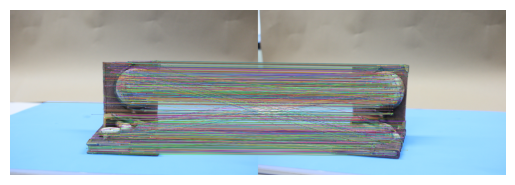

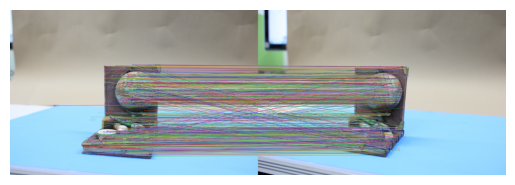

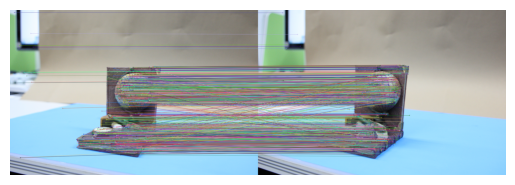

In [3]:
# Plot matches
for i in range(3):
    img_i = cv2.drawMatches(
        images[i],
        keypoints[i],
        images[i + 1],
        keypoints[i + 1],
        matches[(i, i + 1)],
        None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
    )

    plt.imshow(img_i)
    plt.axis("off")
    plt.show()

## Step 2: Eliminate Outliers


In [4]:
# Remove outliers from matches using cv2.findHomography

for i, j in matches.keys():
    kp1 = np.array([keypoints[i][m.queryIdx].pt for m in matches[(i, j)]])
    kp2 = np.array([keypoints[j][m.trainIdx].pt for m in matches[(i, j)]])

    H, mask = cv2.findHomography(kp1, kp2, cv2.RANSAC, 4.0)

    matches[(i, j)] = [m for m, msk in zip(matches[(i, j)], mask) if msk]

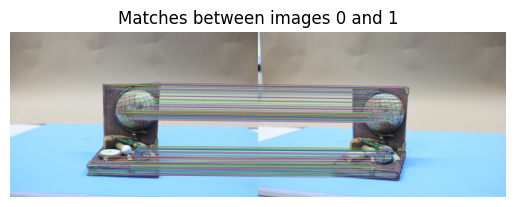

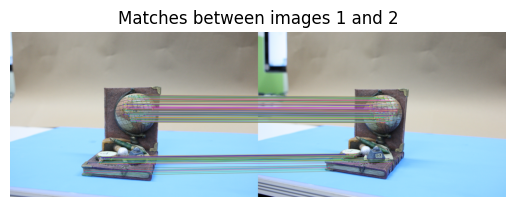

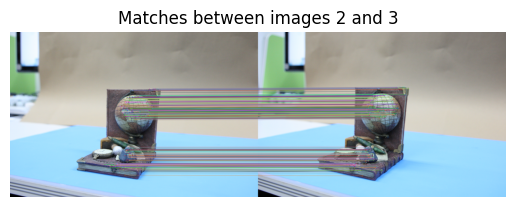

In [5]:
# Plot matches
for i in range(3):
    img_i = cv2.drawMatches(
        images[i],
        keypoints[i],
        images[i + 1],
        keypoints[i + 1],
        matches[(i, i + 1)],
        None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
    )

    plt.title(f"Matches between images {i} and {i + 1}")
    plt.imshow(img_i)
    plt.axis("off")
    plt.show()

## Step 3: Essential Matrix Estimation


In [6]:
# Find the best image pair (with the most matches)
best_pair_idx = np.argmax([len(m) for m in matches.values()])
best_matches = list(matches.items())[best_pair_idx][1]

print(f"Number of matches in best pair: {len(best_matches)}")
best_pair_i, best_pair_j = list(matches.keys())[best_pair_idx]
print(f"Best pair: {(i,j)}")

# Get points from matches
pts1 = np.float32([keypoints[best_pair_i][m.queryIdx].pt for m in best_matches])
pts2 = np.float32([keypoints[best_pair_j][m.trainIdx].pt for m in best_matches])

# Compute the essential matrix
K = np.array(
    [
        [1698.873755, 0.000000, 971.7497705],
        [0.000000, 1698.8796645, 647.7488275],
        [0.000000, 0.000000, 1.000000],
    ]
)
E, mask = cv2.findEssentialMat(
    pts1, pts2, K, method=cv2.RANSAC, prob=0.999, threshold=1.0
)

Number of matches in best pair: 1132
Best pair: (2, 31)


In [7]:
num_outliers = np.sum(mask == 0)
print(f"Number of outliers: {num_outliers}")

num_inliers = np.sum(mask == 1)
print(f"Number of inliers: {num_inliers}")

Number of outliers: 55
Number of inliers: 1077


## Step 4: Camera Pose Estimation


In [8]:
R1, R2, t = cv2.decomposeEssentialMat(E)

# Select the correct rotation and translation
P1 = np.hstack((np.eye(3), np.zeros((3, 1))))
P2s = [
    np.hstack((R1, t)),
    np.hstack((R1, -t)),
    np.hstack((R2, t)),
    np.hstack((R2, -t)),
]

# Triangulate points
points = cv2.triangulatePoints(K @ P1, K @ P2s[0], pts1.T, pts2.T)
points /= points[3]

# Select the correct P2
P2 = None
for P2_i in P2s:
    points_i = cv2.triangulatePoints(K @ P1, K @ P2_i, pts1.T, pts2.T)
    points_i /= points_i[3]
    if np.all(points_i[2] > 0):
        P2 = P2_i
        points = points_i
        break

print("R:", P2[:, :3])
print("t:", P2[:, 3])

# Double check the results
_, R_, t_, mask = cv2.recoverPose(E, pts1, pts2, K)
print(f"{np.allclose(R_, P2[:, :3])=}")
print(f"{np.allclose(t_.T, P2[:, 3])=}")

R: [[ 0.9956387   0.0904666  -0.02278973]
 [-0.09067745  0.99584495 -0.00839292]
 [ 0.02193576  0.01042283  0.99970505]]
t: [ 0.50307496  0.48666055 -0.71419682]
np.allclose(R_, P2[:, :3])=True
np.allclose(t_.T, P2[:, 3])=True


In [9]:
# Reconstruct 3D points using cv2.triangulatePoints
points = cv2.triangulatePoints(K @ P1, K @ P2, pts1.T, pts2.T)
points /= points[3]

In [10]:
import open3d as o3d

cloud = o3d.geometry.PointCloud()
cloud.points = o3d.utility.Vector3dVector(points.T[:, :3])

o3d.io.write_point_cloud(f"{data_out}/{data_set}-2.ply", cloud)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


True

# Step 5: Growing step


In [20]:
# For each image not seen/processed (else skip):
# Get points from matches
# Estimate P matrix using solvePnP with RANSAC and triangulate points
# Add new points to the point cloud

# Sort matches (and keys) by number of matches
best_pairs = sorted(matches.items(), key=lambda item: len(item[1]), reverse=True)

K = np.array(
    [
        [1698.873755, 0.000000, 971.7497705],
        [0.000000, 1698.8796645, 647.7488275],
        [0.000000, 0.000000, 1.000000],
    ]
)
for k_, ((i, j), m) in enumerate(best_pairs):
    if k_ == 0:
        continue

    # Get points from matches
    pts1 = np.float32([keypoints[i][m.queryIdx].pt for m in matches[(i, j)]])
    pts2 = np.float32([keypoints[j][m.trainIdx].pt for m in matches[(i, j)]])

    # Compute the essential matrix
    E, mask = cv2.findEssentialMat(
        pts1, pts2, K, method=cv2.RANSAC, prob=0.999, threshold=1.0
    )

    # Estimate P matrix using solvePnP with best_keys
    _, R, t, mask = cv2.recoverPose(E, pts1, pts2, K)

    # Triangulate points
    P2 = np.hstack((R, t))
    points = cv2.triangulatePoints(K @ P1, K @ P2, pts1.T, pts2.T)
    points /= points[3]

    # Add new points to the point cloud
    cloud.points = o3d.utility.Vector3dVector(
        np.vstack((cloud.points, points.T[:, :3]))
    )

    # Save point cloud
    o3d.io.write_point_cloud(f"{data_out}/{data_set}-{k_ + 2}.ply", cloud)